![ALT_TEXT_FOR_SCREEN_READERS](./header.png)

# Exercise 4.C OCR supported LLM Information Extraction

The goal of this exercise is to build an agent demo which allows you to talk about the content of documents. The method behind this exercise is called retrieval augmented generation (RAG).
The detailed tasks in this exercise are:
- install a local large language model using the application Ollama
- setup a new environment with the required packages
- implement a simple chatbot using langchain[2]
- test the chatbot on a specific technical document

We are using Ollama[1] for local execution of the LLM and the framework langchain[2] for the access to the model.

- [1] https://ollama.com/
- [2] https://www.mistral.ai/

# Considerations

- Read the tutorials carefully, especially [1]
- Install Ollama on your computer
- Install additional software packages into the environment by uncommenting the pip install commands one time
- Select a model based on your memory size of the laptop
- This is less a coding example, rather just the integration with a local LLM

# Requirements

- R0: Install the required packages using the pip commands
- R1: Install the Ollama software
- R2: Find a model which is running on your machine
- R3: Start the server for the model
- R4: Connect the server to the notebook
- R5: Run the code parts until the first query
- R6: Improve your query according to the slides learned in the class


# Setup

In [1]:
%pip install -qU mistralai

Note: you may need to restart the kernel to use updated packages.


# Imports

In [2]:
import os
from dotenv import load_dotenv
import pprint
from mistralai import Mistral
import base64
import mimetypes

In [3]:
#
# the api key has to be written in a .env file in this folder. Content: MISTRAL_API_KEY=xc.....
#
load_dotenv()
api_key = os.environ["MISTRAL_API_KEY"]

# Prepare LLM

In [4]:
client = Mistral(api_key=api_key)

# OCR a single Image

In [5]:
image_file_receipt = "./documents/graph1.png"

In [6]:
def load_image(image_path):
  mime_type, _ = mimetypes.guess_type(image_path)
  with open(image_path, "rb") as image_file:
    image_data = image_file.read()
  base64_encoded = base64.b64encode(image_data).decode('utf-8')
  base64_url = f"data:{mime_type};base64,{base64_encoded}"
  return base64_url

In [7]:
ocr_response = client.ocr.process(
  model="mistral-ocr-latest",
  document={
    "type": "image_url",
    "image_url": load_image(image_file_receipt),
  },
  include_image_base64=True,
)

pages=[OCRPageObject(index=0, markdown='# Figure 3 \n\nPercentage change in viscosity and yield point of a RTV-1 alkoxy sealant compound after storage for 56 days at $50^{\\circ} \\mathrm{C}$\n![img-0.jpeg](img-0.jpeg)\n\nViscosity Pa*s Yield point Pa', images=[OCRImageObject(id='img-0.jpeg', top_left_x=28, top_left_y=178, bottom_right_x=1026, bottom_right_y=704, image_base64='')], dimensions=OCRPageDimensions(dpi=200, height=876, width=1068))] model='mistral-ocr-2503-completion' usage_info=OCRUsageInfo(pages_processed=1, doc_size_bytes=86758)

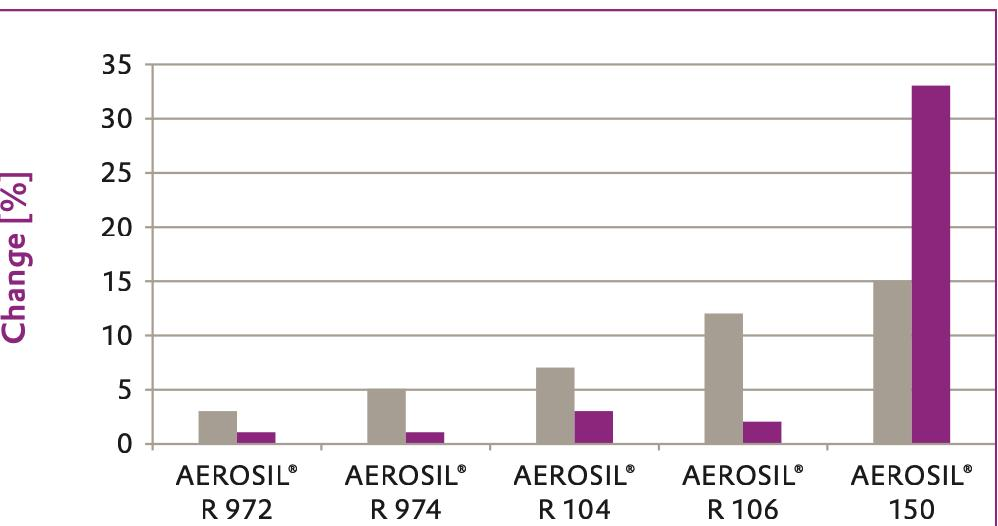

In [8]:
print(ocr_response)

In [9]:
from IPython.display import Markdown
from IPython.display import Image, display, HTML

from base64 import b64decode

In [10]:
def printmd(string):
    display(Markdown(string))

# Figure 3 

Percentage change in viscosity and yield point of a RTV-1 alkoxy sealant compound after storage for 56 days at $50^{\circ} \mathrm{C}$
![img-0.jpeg](img-0.jpeg)

Viscosity Pa*s Yield point Pa


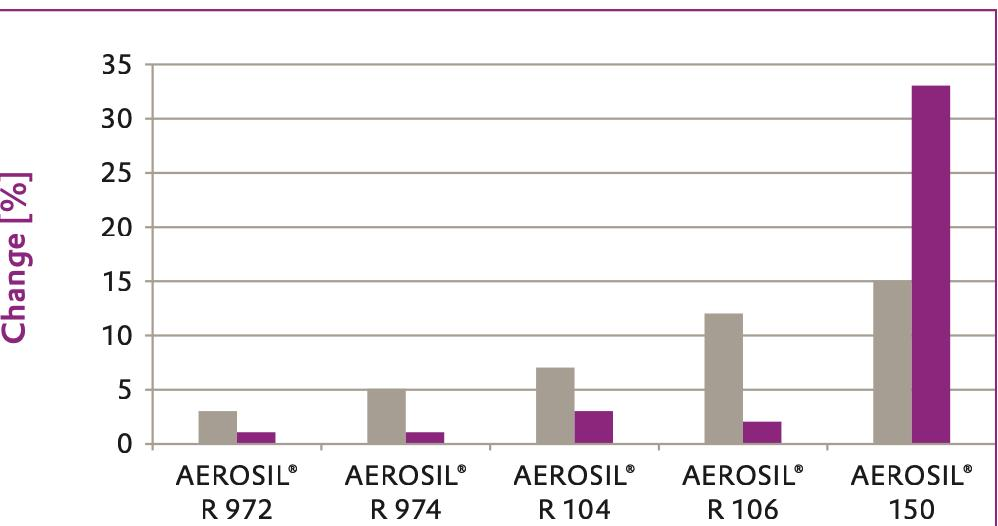

In [11]:
for page in ocr_response.pages:
  printmd(page.markdown)
  for image in page.images:
      base64_str = image.image_base64  # Assuming this is the full Base64 string
      img_html = f'<img src="{base64_str}" style="max-width: 500px;">'  # Adjust size if needed
      display(HTML(img_html))
      #print(image_raw)
      #image_object = Image(image_raw,embed=True, format="jpeg")
      #image_object = Image(data=b64decode(image.image_base64),embed=True)
      #print(image_object)
      #display ( image_object )

# Load and scan complete PDF with LLM

In [12]:
#
# Define PDF file to read
#
file_path = "./documents/graph2.pdf"

In [13]:
def upload_pdf(filename):
  uploaded_pdf = client.files.upload(
    file={
      "file_name": filename,
      "content": open(filename, "rb"),
    },
    purpose="ocr"
  )
  signed_url = client.files.get_signed_url(file_id=uploaded_pdf.id)
  return signed_url.url

In [14]:
prompt = """
Explain this article in detail for experts in the field. 
Take special care for the diagram and the relations shown in diagrams.
"""

In [15]:
messages = [
  {
    "role": "user",
    "content": [
      {
        "type": "text",
        "text": prompt,
      },
      {
        "type": "document_url",
        "document_url": upload_pdf(file_path),
      },
    ],
  }
]

In [16]:
chat_response = client.chat.complete(
  model="mistral-small-latest",
  messages=messages,
)

In [17]:
print(chat_response.choices[0].message.content)

This article presents a bar graph (Figure 3) that illustrates the percentage change in viscosity and yield point of a Room Temperature Vulcanizing (RTV-1) alkoxy sealant compound after storage for 56 days at 50°C. The data is categorized by different types of AEROSIL® fumed silica additives, which are commonly used to modify the rheological properties of sealants.

### Detailed Explanation:

#### Graph Components:
1. **X-Axis (Horizontal Axis):**
   - Represents different types of AEROSIL® fumed silica additives used in the sealant compound.
   - The specific types of AEROSIL® shown are R 972, R 974, R 104, R 106, and 150.

2. **Y-Axis (Vertical Axis):**
   - Represents the percentage change in viscosity and yield point.
   - The scale ranges from 0% to 35%.

3. **Bars:**
   - **Gray Bars:** Represent the percentage change in viscosity (Pa*s).
   - **Purple Bars:** Represent the percentage change in yield point (Pa).

#### Observations:
1. **AEROSIL® R 972:**
   - Viscosity change: App